# Inference of free-space vortices from pressure using MCMC

In [1]:
using Revise

In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [3]:
using PotentialFlow

In [4]:
using CairoMakie
#using Plots
#pyplot()

In [5]:
using LaTeXStrings

In [6]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

### Truth

In [171]:
t = 0.0
δ_true = 0.01


#=
# For placing the vortices randomly
=#
#=
Nv_cluster = 5
Nv_per_cluster = 1
Nv_true = Nv_cluster*Nv_per_cluster 

xr = (-1.5,1.5)
yr = (-1.0,1.0)
Γr = (-2.0,2.0)

σx = 0.03
σΓ = 0.03
zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)
=#

#=
Prescribed placement
=#
zv = [0.5+1.0im]
Γv = [1.0]
#zv = [-1.0+0.75im,0.75+0.5im]  # [-1.0+0.75im,0.75+0.5im]
#Γv = [1.2,0.4] #[1.2,-1.0]
#zv = [-1.0+0.75im,0.25+0.5im,0.75+0.75im]
#Γv = [1.0,-1.2,1.4]
Nv_true = length(zv);

#=
x_true = [-0.7611581857580003,
  0.7266716391085539,
  0.04730897238217636,
  0.4637373841856715,
  0.6347931827658125,
  1.6466841098688845];
  zv, Γv = state_to_positions_and_strengths(x_true)
  Nv_true =  length(zv)
=#


### Create sensors

In [982]:
# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle
rsens = 2.0
Nsens = 21
θsens = range(0,2π,length=Nsens+1)
#sens = rsens*exp.(im*θsens[1:end-1]);

# sensors in lines
Nsens = 3
ϵsens = 0.0
lowerrow = range(-1,1,length=Nsens) .+ (-0.5ϵsens .+ ϵsens*rand(Nsens))*im
#upperrow = range(-2.0,2.0,length=Nsens) .+ 1.0*im
#leftside = im*range(-1.0,3.0,length=Nsens) .- 1.0
#rightside = im*range(-1.0,3.0,length=Nsens) .+ 1.0
sens = vcat(lowerrow,);  #upperrow);

### Set some plotting themes

In [917]:
xytheme = Theme(
        Axis = (aspect=DataAspect(),xlabel=L"x",ylabel=L"y"),
        palette = (color = Makie.wong_colors(),),
        Lines = (cycle = [:color],),
        Scatter = (cycle = [:color],)
    );

sensortheme = Theme(
    Axis = (xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty")
);

#### Set up the observer for the truth data

In [983]:
config_true = VortexConfig(Nv_true, δ_true, body=LowRankVortex.NoWall)

truez = zv

vort = Vortex.Blob.(zv,Γv,δ_true)
x_true = lagrange_to_state(vort,config_true)

obs_true = PressureObservations(sens,config_true);

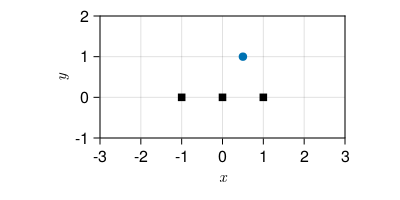

In [984]:
with_theme(xytheme) do
    f = Figure(;resolution = (400, 200))
    ax = f[1,1] = Axis(f;limits=(-3,3,-1,2))
    show_singularities!(ax,x_true,obs_true)
    plot_sensors!(ax,obs_true)
    f
end

### Evaluate the true sensor data and add noise

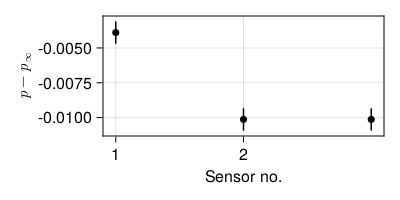

In [985]:
add_noise = false

# evaluate data without noise
ystar0 = observations(x_true,t,obs_true);

# set measurement noise level
ϵmeas_data = [2.5e-4,3.75e-4,5e-4,6.25e-4,8e-4,1e-3,1.5e-3,2e-3,3e-3,4e-3];
ϵmeas = ϵmeas_data[5] #5e-4 #1e-3

Σϵ = Diagonal(ϵmeas^2*ones(length(sens)))

noisedist = MvNormal(zero(ystar0),Σϵ)
ystar = ystar0
if add_noise
    ystar += rand(noisedist)
end

with_theme(sensortheme) do
    f = Figure(;resolution = (400, 200))
    ax = f[1,1] = Axis(f)
    plot_sensor_data!(ax,ystar0,obs_true;sensor_noise=ϵmeas*ones(length(ystar)))
    f
end

## Vortex estimation

In [986]:
Nv_estimator = 1
δ = 0.01

config_estimator = VortexConfig(Nv_estimator, δ, body=LowRankVortex.NoWall)


# ranges to confine the prior mean to
xr = (-2,2)
yr = (-2,2) #(0.01,2.0)
#dΓr = (-4,4)
#Γtotr = (0.01,2)
Γr = (-2,2)
bounds = create_state_bounds(xr,yr,Γr,config_estimator);


obs = PressureObservations(sens,config_estimator);

# Function for the log of the joint distribution
function my_logp̃(x::Vector)
    logp̃ = normal_loglikelihood(x,t,ystar,Σϵ,obs)
    logp̃ += log_uniform(x,bounds)
end

my_logp̃ (generic function with 1 method)

### MCMC approach

In [987]:
## Parallel tempering ##
# Set the number of chains and the inverse "temperature" of each chain
nchain = 5
β = 5.0.^(range(0,-4,length=nchain));

In [988]:
Ntrial = 10000
propvarX = 0.01^2 # 0.01^2
propvarY = 0.01^2 # 0.01^2
propvarΓ = 0.05^2 # 0.01^2
propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator);

# scale the covariance of each chain by its temperature
propvars = [propvar/β[i] for i = 1:nchain];

In [989]:
#xseed = copy(x_true)
xseed = generate_random_state(xr,yr,Γr,obs.config)
#xseed = generate_random_state(xr,yr,dΓr,Γtotr,obs.config)
xseeds = [xseed for n = 1:nchain]
#xseeds = [generate_random_state(xr,yr,Γr,obs.config) for n = 1:nchain]

x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,my_logp̃,propvars;β=β,process_state=x->state_filter!(x,obs));

In [990]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.5672865426914617
 0.6104779044191162
 0.6064787042591482
 0.6610677864427115
 0.5776844631073785

In [991]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.06630686198920586
 0.13636363636363635
 0.19020866773675763
 0.2660016625103907

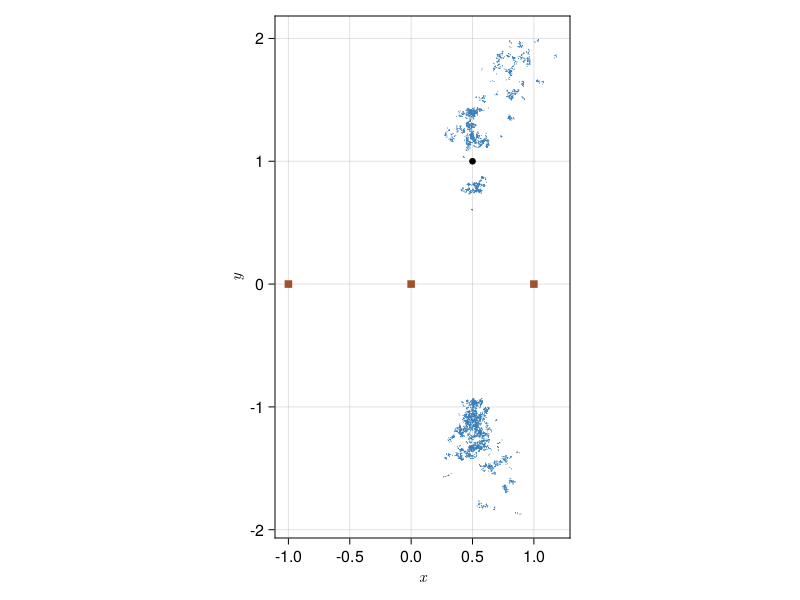

In [992]:
with_theme(xytheme) do
    f = Figure()
    ax = f[1,1] = Axis(f)
    show_singularity_samples!(ax,x_data[1],obs,nskip=1,colormap=:Set1_3)  #colormap=:Set1_3 :RdBu_3)
    scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=8,color=:black,strokewidth=1)
    plot_sensors!(ax,obs,color=:sienna)
    f
end

#### Build from the first chain 

In [993]:
#β = 2.0.^(range(0,-3,length=nchain));

In [994]:
Ntrial = 600000
propvarX = 0.005^2 # 0.01^2
propvarY = 0.005^2 # 0.01^2
propvarΓ = 0.005^2 # 0.01^2
propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator);

propvars = [propvar/β[i] for i = 1:nchain];

In [995]:
xseeds = [x_data[j][:,end] for j = 1:nchain]
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,my_logp̃,propvars;β=β,process_state=x->state_filter!(x,obs));

In [996]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.928346905510315
 0.933270222432592
 0.9268335772214092
 0.9211135962880124
 0.8796337345542181

In [997]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.0909187495019788
 0.14302493193102345
 0.2158461210571185
 0.28115546274730274

#### Only save every  `nskip`th sample to remove data correlations

In [998]:
nskip = 100
x_decorr_data = x_data[1][:,1:nskip:end];

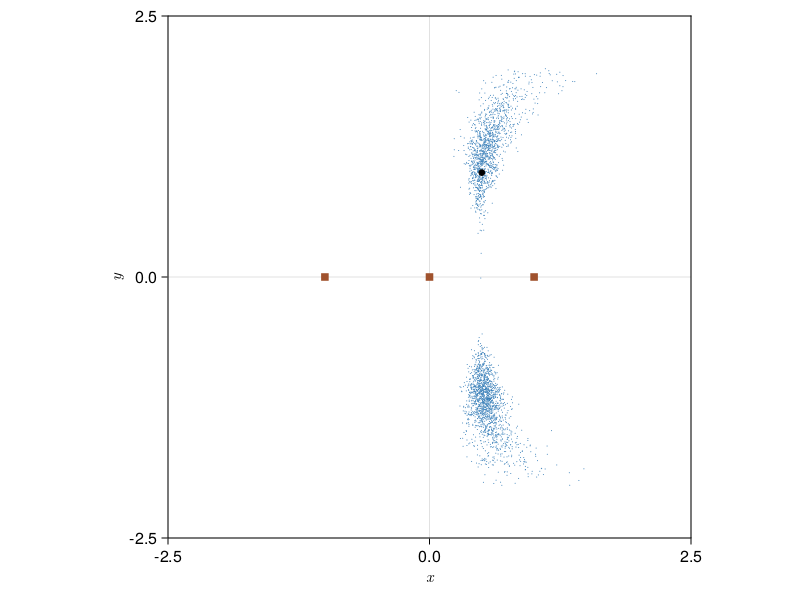

In [1000]:
with_theme(xytheme) do
    f = Figure()
    ax = f[1,1] = Axis(f,limits=(-2.5,2.5,-2.5,2.5))
    show_singularity_samples!(ax,x_decorr_data,obs,colormap=:Set1_3) #RdBu_3)
    scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=8,color=:black,strokewidth=1)
    plot_sensors!(ax,obs,color=:sienna)
    f
end

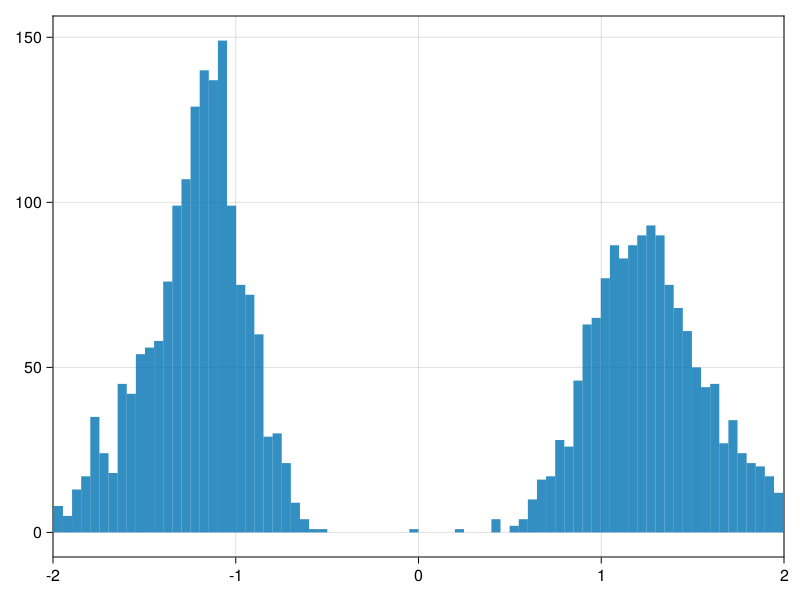

In [1001]:
data_histogram(x_decorr_data[2,:])

In [936]:
K = 1
gm = classify_by_gmm(K,x_decorr_data);

In [937]:
weights(gm)

1-element Vector{Float64}:
 1.0

In [938]:
alpha_threshold = 0.0 # 0.9
gmj = gm

# take only the top `alpha_threshold` percent
maxw = maximum(weights(gmj))
idx = weights(gmj).>= alpha_threshold*maxw
wts = weights(gmj)[idx]./sum(weights(gmj)[idx])
_, best_comp = findmax(wts)

Σ = covars(gmj)[idx,:]
Σ = [Σ[j] for j = 1:length(Σ)]; # add the blob size to the covariance for vorticity field

xm = transpose(means(gmj)[idx,:])

3×1 transpose(::Matrix{Float64}) with eltype Float64:
 1.1699241618704885
 1.480915103534051
 1.4153663512032888

In [939]:
LowRankVortex.align_vector_through_flips!(xm,Σ,best_comp,config_estimator)
xm

3×1 transpose(::Matrix{Float64}) with eltype Float64:
 1.1699241618704885
 1.480915103534051
 1.4153663512032888

In [940]:
#nsens_8em4 = Int[]
#Σ_nsens_8em4 = Matrix[]

In [941]:
if (K==1)
    push!(Σ_nsens_8em4,copy(Σ[1]))
    push!(nsens_8em4,length(sens))
end

5-element Vector{Int64}:
 6
 5
 4
 3
 2

In [942]:
Σ_0 = state_covariance(δ^2,δ^2,0.0,config_estimator);
Σv = [Σ[j] .+ Σ_0 for j = 1:length(Σ)]; # add the blob size to the covariance for vorticity field

#### Contruct the filename descriptor

In [943]:
ds_string = string(1000+round(Int,100*abs(obs.sens[end]-obs.sens[1])/(length(obs.sens)-1)))[2:end]
ns_string = string(length(obs.sens))
nv_string = string(obs.config.Nv)
K_string = string(K)

alpha_string = string(round(Int,100+100*alpha_threshold))[2:3]
delta_string = string(round(Int,1000+100*δ_true))[2:4]

filename = nv_string*"vortex-1truth-K"*K_string*"-delta"*delta_string*"-"*ns_string*"sensor-ds"*ds_string*"-top"*alpha_string*"-noise5em4"

"1vortex-1truth-K1-delta001-2sensor-ds200-top00-noise5em4"

In [944]:
plottype = :samples
#plottype = :vorticity

saveplot = false

false

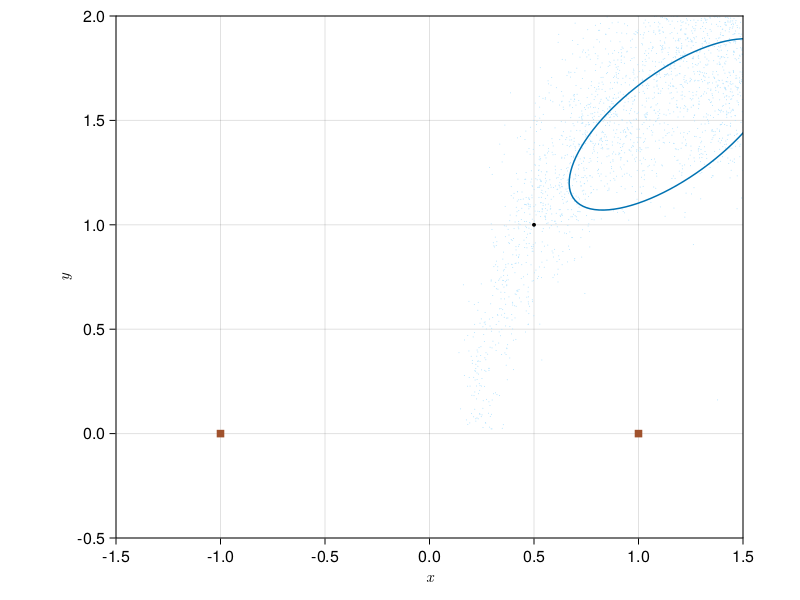

In [945]:
with_theme(xytheme) do
    f = Figure()
    ax = f[1,1] = Axis(f)

    if plottype == :samples
        show_singularity_samples!(ax,x_decorr_data,obs,nskip=1) #colormap=:Set1_3:RdBu_3,nskip=1)
        #singularity_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs,color=:red)
        singularity_ellipses!(ax,xm,Σ,wts,obs)
    
    elseif plottype == :vorticity
        lev = range(-1,1,length=14)
        plot_expected_sourcefield!(ax,xm,Σv,wts,obs,xlims=(-2,2),ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,levels=lev)
        #plot_expected_sourcefield!(ax,xm[:,best_comp],Σ[best_comp],obs,ylims=(-1,2.5),colormap=:lighttemperaturemap,linewidth=2,levels=range(-1,1,length=14))

        Σ_true = state_covariance(δ_true^2,δ_true^2,0.0,config_true);
        plot_expected_sourcefield!(ax,x_true,Σ_true,obs_true,ylims=(-1,2),colormap=cgrad(:lighttemperaturemap,rev=true),linestyle=:dot,linewidth=1,levels=lev)
    end

    scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=4,color=:black,strokewidth=1)
    plot_sensors!(ax,obs,color=:sienna)
    ylims!(ax,(-0.5,2.0))
    xlims!(ax,(-1.5,1.5))
    
    fullname = String(plottype)*"-"*filename*".pdf" 
    saveplot && save(fullname,f)
    f
end

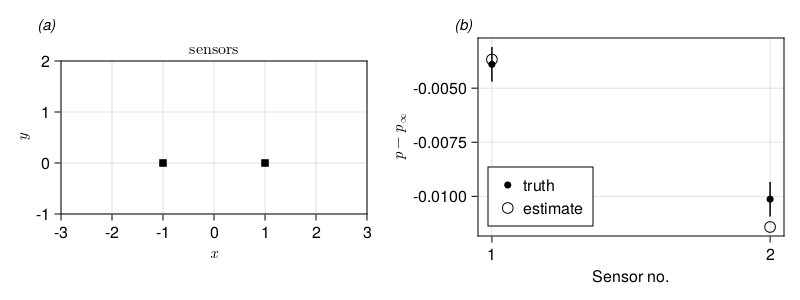

In [946]:
best_comp = 1

f = Figure(;resolution=(800,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()

axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-3,3,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
plot_sensors!(axleft,obs)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty")
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:lb)


for (label, layout) in zip(["(a)", "(b)"], [ga, gb])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("basicdata-1vortex-3sensor.pdf",f)

f

#### Plotting the pressure

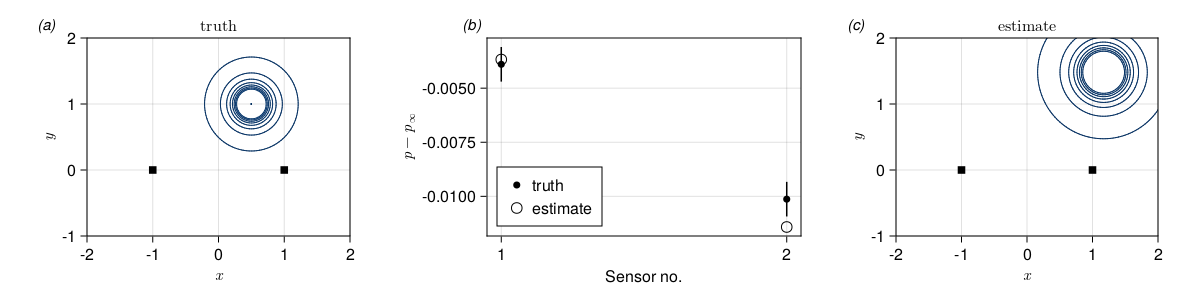

In [947]:
l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
plot_pressure_field!(axleft,x_true,obs_true,levels=range(-0.25,0.2,length=15))
plot_pressure_field!(axright,xm[:,best_comp],obs,levels=range(-0.25,0.2,length=15),mode=:relative)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:lb)


for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
saveplot && save("pressure-"*filename*".pdf",f)

f

In [556]:
Σ_nsens_5em4[1]

3×3 Matrix{Float64}:
 0.0020447   0.00206365  0.00190248
 0.00206365  0.00665285  0.00569608
 0.00190248  0.00569608  0.00502218

### Plot covariances

In [501]:
x_id, y_id, Γ_id = get_singularity_ids(1,config_estimator)

(1, 2, 3)

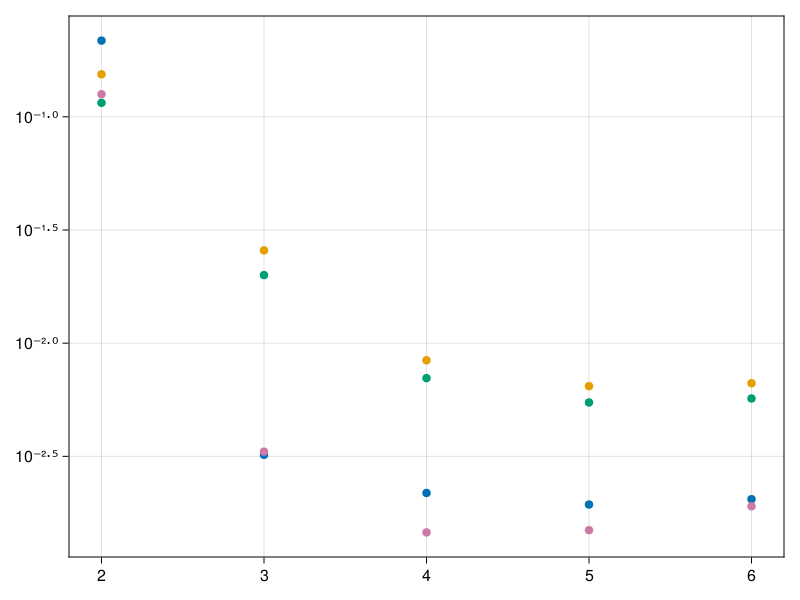

In [520]:
f = Figure()
ax = f[1,1] = Axis(f;yscale=log10)

scatter!(ax,nsens,map(Σ -> Σ[x_id,x_id],Σ_nsens))
scatter!(ax,nsens,map(Σ -> Σ[y_id,y_id],Σ_nsens))
scatter!(ax,nsens,map(Σ -> Σ[Γ_id,y_id],Σ_nsens))
scatter!(ax,nsens,map(Σ -> Σ[Γ_id,x_id],Σ_nsens))
f

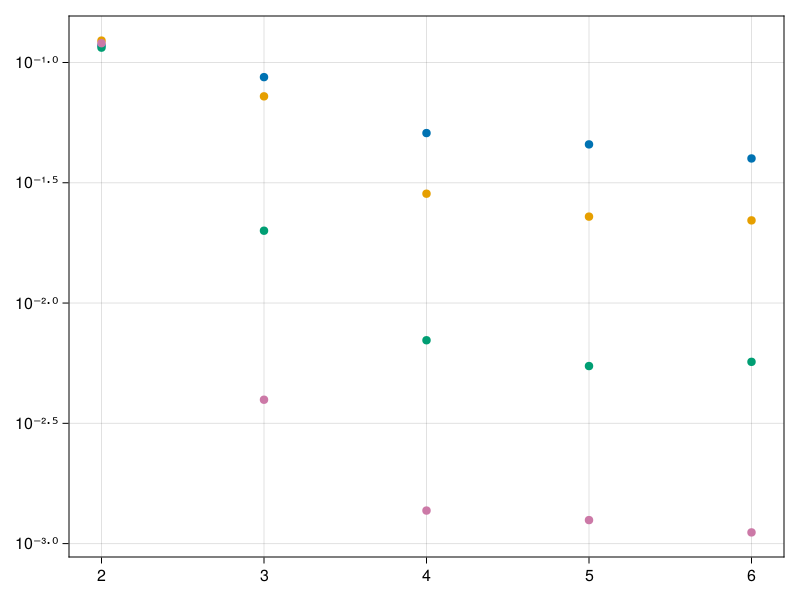

In [971]:
f = Figure()
ax = f[1,1] = Axis(f;yscale=log10)
scatter!(ax,nsens,map(Σ -> Σ[y_id,Γ_id],Σ_nsens_1em3),label=L"10^{-3}")
scatter!(ax,nsens,map(Σ -> Σ[y_id,Γ_id],Σ_nsens_8em4))
scatter!(ax,nsens,map(Σ -> Σ[y_id,Γ_id],Σ_nsens_5em4))
scatter!(ax,nsens,map(Σ -> Σ[y_id,Γ_id],Σ_nsens_25em4))

f

In [804]:
(log10(Σ_nsens_1em4[2][x_id,x_id])-log10(Σ_nsens_25em4[2][x_id,x_id]))/(log10(5e-4)-log10(2.5e-4))

2.124175329434497

In [954]:
(log10(Σ_nsens_1em3[2][y_id,Γ_id])-log10(Σ_nsens_5em4[2][y_id,Γ_id]))/(log10(1e-3)-log10(5e-4))

3.0609472818515906

In [950]:
(log10(Σ_nsens_8em4[2][y_id,y_id])-log10(Σ_nsens_5em4[2][y_id,y_id]))/(log10(8e-4)-log10(5e-4))

3.0210321977602916

In [969]:
F = eigen(Σ_nsens_25em4[1])

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
3-element Vector{Float64}:
 1.7825873082014322e-5
 0.0002845179122849064
 0.0023778001377928026
vectors:
3×3 Matrix{Float64}:
 -0.0480913   0.971931  -0.230298
 -0.647487   -0.205895  -0.733735
  0.760557   -0.113829  -0.639215

In [963]:
x_true

3-element Vector{Float64}:
 0.3635
 0.727
 0.727

In [970]:
F.vectors'*x_true

3-element Vector{Float64}:
  0.08902467914190348
  0.16624179899318392
 -1.4880988780222877

In [966]:
eigen

search: eigen eigen! Eigen GeneralizedEigen weighted_color_mean eigvecs



```
eigen(A; permute::Bool=true, scale::Bool=true, sortby) -> Eigen
```

Compute the eigenvalue decomposition of `A`, returning an [`Eigen`](@ref) factorization object `F` which contains the eigenvalues in `F.values` and the eigenvectors in the columns of the matrix `F.vectors`. (The `k`th eigenvector can be obtained from the slice `F.vectors[:, k]`.)

Iterating the decomposition produces the components `F.values` and `F.vectors`.

The following functions are available for `Eigen` objects: [`inv`](@ref), [`det`](@ref), and [`isposdef`](@ref).

For general nonsymmetric matrices it is possible to specify how the matrix is balanced before the eigenvector calculation. The option `permute=true` permutes the matrix to become closer to upper triangular, and `scale=true` scales the matrix by its diagonal elements to make rows and columns more equal in norm. The default is `true` for both options.

By default, the eigenvalues and vectors are sorted lexicographically by `(real(λ),imag(λ))`. A different comparison function `by(λ)` can be passed to `sortby`, or you can pass `sortby=nothing` to leave the eigenvalues in an arbitrary order.   Some special matrix types (e.g. [`Diagonal`](@ref) or [`SymTridiagonal`](@ref)) may implement their own sorting convention and not accept a `sortby` keyword.

# Examples

```jldoctest
julia> F = eigen([1.0 0.0 0.0; 0.0 3.0 0.0; 0.0 0.0 18.0])
Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
3-element Vector{Float64}:
  1.0
  3.0
 18.0
vectors:
3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

julia> F.values
3-element Vector{Float64}:
  1.0
  3.0
 18.0

julia> F.vectors
3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

julia> vals, vecs = F; # destructuring via iteration

julia> vals == F.values && vecs == F.vectors
true
```

---

```
eigen(A, B; sortby) -> GeneralizedEigen
```

Compute the generalized eigenvalue decomposition of `A` and `B`, returning a [`GeneralizedEigen`](@ref) factorization object `F` which contains the generalized eigenvalues in `F.values` and the generalized eigenvectors in the columns of the matrix `F.vectors`. (The `k`th generalized eigenvector can be obtained from the slice `F.vectors[:, k]`.)

Iterating the decomposition produces the components `F.values` and `F.vectors`.

By default, the eigenvalues and vectors are sorted lexicographically by `(real(λ),imag(λ))`. A different comparison function `by(λ)` can be passed to `sortby`, or you can pass `sortby=nothing` to leave the eigenvalues in an arbitrary order.

# Examples

```jldoctest
julia> A = [1 0; 0 -1]
2×2 Matrix{Int64}:
 1   0
 0  -1

julia> B = [0 1; 1 0]
2×2 Matrix{Int64}:
 0  1
 1  0

julia> F = eigen(A, B);

julia> F.values
2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im

julia> F.vectors
2×2 Matrix{ComplexF64}:
  0.0+1.0im   0.0-1.0im
 -1.0+0.0im  -1.0-0.0im

julia> vals, vecs = F; # destructuring via iteration

julia> vals == F.values && vecs == F.vectors
true
```

---

```
eigen(A::Union{SymTridiagonal, Hermitian, Symmetric}, irange::UnitRange) -> Eigen
```

Compute the eigenvalue decomposition of `A`, returning an [`Eigen`](@ref) factorization object `F` which contains the eigenvalues in `F.values` and the eigenvectors in the columns of the matrix `F.vectors`. (The `k`th eigenvector can be obtained from the slice `F.vectors[:, k]`.)

Iterating the decomposition produces the components `F.values` and `F.vectors`.

The following functions are available for `Eigen` objects: [`inv`](@ref), [`det`](@ref), and [`isposdef`](@ref).

The [`UnitRange`](@ref) `irange` specifies indices of the sorted eigenvalues to search for.

!!! note
    If `irange` is not `1:n`, where `n` is the dimension of `A`, then the returned factorization will be a *truncated* factorization.


---

```
eigen(A::Union{SymTridiagonal, Hermitian, Symmetric}, vl::Real, vu::Real) -> Eigen
```

Compute the eigenvalue decomposition of `A`, returning an [`Eigen`](@ref) factorization object `F` which contains the eigenvalues in `F.values` and the eigenvectors in the columns of the matrix `F.vectors`. (The `k`th eigenvector can be obtained from the slice `F.vectors[:, k]`.)

Iterating the decomposition produces the components `F.values` and `F.vectors`.

The following functions are available for `Eigen` objects: [`inv`](@ref), [`det`](@ref), and [`isposdef`](@ref).

`vl` is the lower bound of the window of eigenvalues to search for, and `vu` is the upper bound.

!!! note
    If [`vl`, `vu`] does not contain all eigenvalues of `A`, then the returned factorization will be a *truncated* factorization.

